# Case Study A-Z: A Machine Learning powered Strategy (DNN)

_Disclaimer: <br>
The following illustrative example is for general information and educational purposes only. <br>
It is neither investment advice nor a recommendation to trade, invest or take whatsoever actions.<br>
The below code should only be used in combination with an Oanda/FXCM Practice/Demo Account and NOT with a Live Trading Account._

## Getting and Preparing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import yfinance as yf
import pandas_ta as ta
#pip install zigzag
from zigzag import *

# Preprocessing data
from talib import abstract
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import math # Mathematical functions 


/tmp/ipykernel_16775/3606607027.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


[*********************100%***********************]  1 of 1 completed
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
-1.0
1.0
1.0


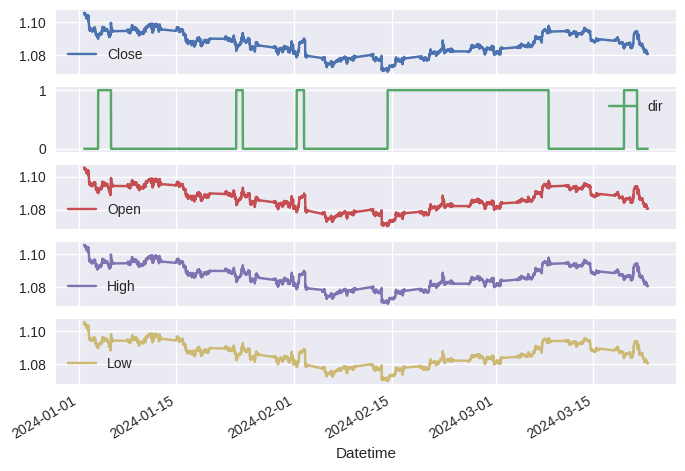

In [2]:
#data = pd.read_csv("DNN_data.csv", parse_dates = ["time"], index_col = "time")
# Data download
symbol = "EURUSD=X"
period ='60d'
interval ='15m'

# load data
def get_yfinance_hist(symbol = "EURUSD=X", period ='1mo', interval ='15m', show_plot = True ):
    df_raw = yf.download(symbol,period= period ,interval=interval)
    df_raw["returns"] = np.log(df_raw.Close.div(df_raw.Close.shift(1)))
    df_raw.dropna(how="any",inplace=True)
    df_raw = df_raw.drop('Volume', axis=1)

    #Convert data into numpy array
    closing_prices = np.asarray(df_raw['Close'])

    #Calculate min/max points
    min_max_points = peak_valley_pivots(closing_prices, 0.008,-0.008)

    #Add as a column to the original df2
    df_raw['Min/Max Points'] = min_max_points

    #Replace all 0s with NaN values
    df_raw['Min/Max Points'] = df_raw['Min/Max Points'].replace(0,np.NaN)#Interpolate

    df_raw['dir'] = 0
    lastValue = 0
    df_raw['Min/Max Points'].fillna(0, inplace=True)
    for i, row in df_raw.iterrows():
        if row['Min/Max Points'] != 0:
            print(row['Min/Max Points'])
            
            if(row['Min/Max Points'] == -1):
              lastValue = 1
        
            if(row['Min/Max Points'] == 1):
              lastValue = 0
        
        df_raw.at[i,'dir'] = lastValue


    if(show_plot):
      plot_cols = ['Close', 'dir', 'Open', 'High', 'Low']
      plot_features = df_raw[plot_cols]
      plot_features.index = df_raw.index
      _ = plot_features.plot(subplots=True)

    df_raw = df_raw.dropna()

    return df_raw

data = get_yfinance_hist(symbol = symbol, period = period, interval= interval )


In [3]:
lags = 1
cols = []
features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]

def add_signal_indicators(df):

    for lag in range(1, lags + 1):
        col = "lag{}".format(lag)
        df[col] = df["returns"].shift(lag)
        cols.append(col)
            
    df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
    cols.append('Ask_Dir')

    df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
    cols.append('SMA')
    df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
    cols.append('SMA_Dir')

    df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
    cols.append('RSI')
    df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
    cols.append('RSI_Dir')

    df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    cols.append('fastk')
    cols.append('fastd')
    df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
    cols.append('fastk_Dir')
    df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)    
    cols.append('fastd_Dir')                
    
    '''    
    df['SMA_10'] = ta.sma(df['Adj Close'],length=10)
    cols.append('SMA_10')
    df['SMA_30'] = ta.sma(df['Adj Close'],length=30)
    cols.append('SMA_30')
    df['SMA_50'] = ta.sma(df['Adj Close'],length=50)
    cols.append('SMA_50')
    df['SMA_200'] = ta.sma(df['Adj Close'],length=200)
    cols.append('SMA_200')
    '''
    macd = ta.macd(df['Adj Close'], fast=12, slow=26, signal=9)
    df['MACD'] = macd['MACD_12_26_9']
    cols.append('MACD')
    df['MACD_signal'] = macd['MACDs_12_26_9']
    cols.append('MACD_signal')
    df['MACD_hist'] = macd['MACDh_12_26_9']
    cols.append('MACD_hist')
    
    #df['10_cross_30'] = np.where(df['SMA_10'] > df['SMA_30'], 1, 0)
    #cols.append('10_cross_30')
      
    df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] < df['MACD'], 1, 0)
    cols.append('MACD_Signal_MACD')
    
    df['MACD_lim'] = np.where(df['MACD']>0, 1, 0)
    cols.append('MACD_lim')
    '''
    df['abv_50'] = np.where((df['SMA_30']>df['SMA_50'])
                            &(df['SMA_10']>df['SMA_50']), 1, 0)
    cols.append('abv_50')
                            
    df['abv_200'] = np.where((df['SMA_30']>df['SMA_200'])
                            &(df['SMA_10']>df['SMA_200'])
                            &(df['SMA_50']>df['SMA_200']), 1, 0)
    cols.append('abv_200')
    '''
    return df

data = add_signal_indicators(data)

In [4]:
#data["returns"] = data[symbol] / data[symbol].shift()
data["returns"] = np.log(data['Close'] / data['Close'].shift())

## Adding Label/Features

In [5]:
window = 50

In [6]:
df = data.copy()
df.dropna(inplace = True)

In [7]:
df.head()

,Open,High,Low,Close,Adj Close,returns,Min/Max Points,dir,lag1,Ask_Dir,...,RSI_Dir,fastk,fastd,fastk_Dir,fastd_Dir,MACD,MACD_signal,MACD_hist,MACD_Signal_MACD,MACD_lim
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-01-02 04:00:00,1.10278,1.10278,1.10241,1.10241,1.10241,-0.00033,0.00000,0,0.00022,1,...,1,0.00000,50.80720,1,0,-0.00069,-0.00066,-0.00003,0,0
2024-01-02 04:15:00,1.10254,1.10254,1.10229,1.10229,1.10229,-0.00011,0.00000,0,-0.00033,0,...,0,40.15208,40.75085,0,0,-0.00069,-0.00067,-0.00002,0,0
2024-01-02 04:30:00,1.10229,1.10229,1.10205,1.10205,1.10205,-0.00022,0.00000,0,-0.00011,1,...,1,20.99422,20.38210,1,1,-0.00070,-0.00067,-0.00002,0,0
2024-01-02 04:45:00,1.10205,1.10241,1.10193,1.10241,1.10241,0.00033,0.00000,0,-0.00022,0,...,0,100.00000,53.71543,0,1,-0.00067,-0.00067,0.00000,1,0
2024-01-02 05:00:00,1.10254,1.10278,1.10241,1.10266,1.10266,0.00022,0.00000,0,0.00033,1,...,1,81.92065,67.63829,1,1,-0.00062,-0.00066,0.00004,1,0


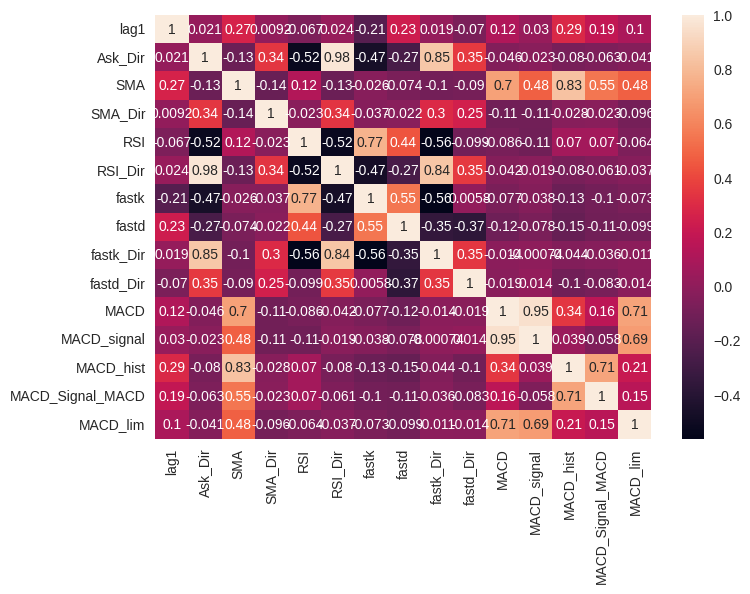

In [8]:
#plotting the heatmap for correlation
ax = sns.heatmap(data[cols].corr(), annot=True)

## Splitting into Train and Test Set

In [9]:
len(df)

5564

In [10]:
split = int(len(df)*0.66)
split

3672

In [11]:
train = df.iloc[:split].copy()

In [12]:
test = df.iloc[split:].copy()

## Feature Scaling (Standardization)

In [13]:
mu, std = train.mean(), train.std() # train set parameters (mu, std) for standardization

In [14]:
train_s = (train - mu) / std # standardization of train set features

## Creating and Fitting the DNN Model

In [15]:
from DNNModel import *


2024-03-22 20:51:25.432046: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 20:51:25.712306: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-22 20:51:25.715754: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-22 20:51:30.122074: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [16]:
# fitting a DNN model with 3 Hidden Layers (50 nodes each) and dropout regularization

set_seeds(100)
model = create_model1(hl = 3, hu = 50, dropout = True, input_dim = len(cols))
model.fit(x = train[cols], y = train["dir"], epochs = 100, verbose = False,
          validation_split = 0.2, shuffle = False, class_weight = cw(train))

In [17]:
model.evaluate(train_s[cols], train["dir"]) # evaluate the fit on the train set

  8/115 [=>............................] - ETA: 0s - loss: 0.6716 - accuracy: 0.6094 

115/115 [==============================] - 2s 14ms/step - loss: 0.6142 - accuracy: 0.7059


[0.6142253279685974, 0.7058823704719543]

In [18]:
pred = model.predict(train_s[cols]) # prediction (probabilities)

115/115 [==============================] - 1s 6ms/step


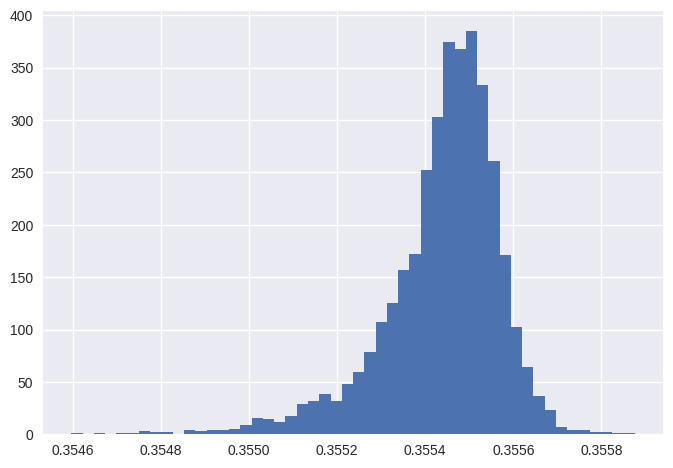

In [19]:
plt.hist(pred, bins = 50)
plt.show()

## Out-Sample Prediction and Forward Testing

In [20]:
test_s = (test - mu) / std # standardization of test set features (with train set parameters!!!)

In [21]:
model.evaluate(test_s[cols], test["dir"])

48/60 [=======================>......] - ETA: 0s - loss: 0.7949 - accuracy: 0.4023

60/60 [==============================] - 1s 10ms/step - loss: 0.7849 - accuracy: 0.4191


[0.7848939299583435, 0.41913318634033203]

In [22]:
pred = model.predict(test_s[cols])

31/60 [==============>...............] - ETA: 0s

60/60 [==============================] - 1s 9ms/step


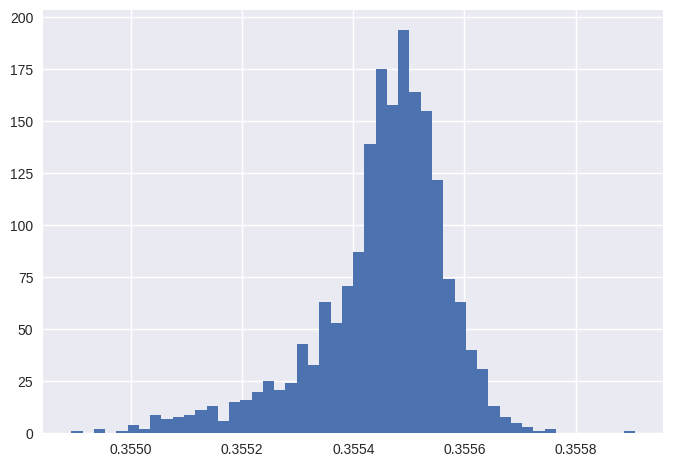

In [23]:
plt.hist(pred, bins = 50);

In [24]:
test["proba"] = model.predict(test_s[cols])

 1/60 [..............................] - ETA: 5s

60/60 [==============================] - 1s 9ms/step


In [25]:
test["position"] = np.where(test.proba < 0.47, -1, np.nan) # 1. short where proba < 0.47

In [26]:
test["position"] = np.where(test.proba > 0.53, 1, test.position) # 2. long where proba > 0.53

In [27]:
test["position"].min()


-1.0

In [28]:
test.index = test.index.tz_convert('UTC')
test["NYTime"] = test.index.tz_convert("America/New_York")
test["hour"] = test.NYTime.dt.hour

TypeError: Cannot convert tz-naive timestamps, use tz_localize to localize

In [ ]:
test["position"] = np.where(~test.hour.between(2, 12), 0, test.position) # 3. neutral in non-busy hours

In [ ]:
test["position"] = test.position.ffill().fillna(0) # 4. in all other cases: hold position

In [ ]:
test.position.value_counts(dropna = False)

0.00000     219
-1.00000    192
Name: position, dtype: int64

In [ ]:
test["strategy"] = test["position"] * test["returns"]

In [ ]:
test["creturns"] = test["returns"].cumsum().apply(np.exp)
test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)

In [ ]:
test["creturns"].describe()

count   411.00000
mean      1.00690
std       0.00396
min       0.99914
25%       1.00380
50%       1.00653
75%       1.01093
max       1.01414
Name: creturns, dtype: float64

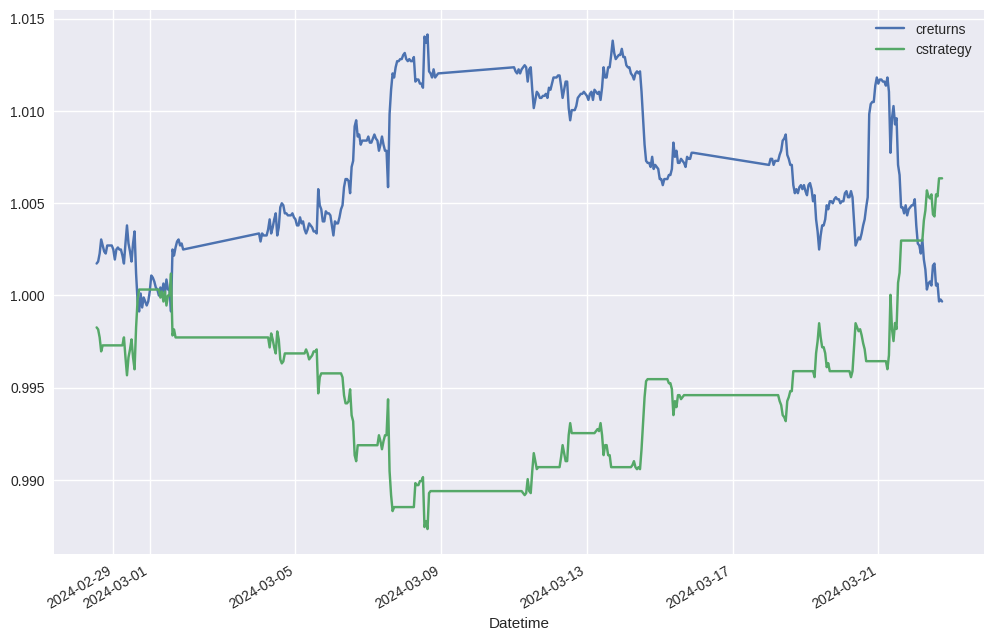

In [ ]:
test[["creturns", "cstrategy"]].plot(figsize = (12, 8))
plt.show()

In [ ]:
ptc = 0.000059

In [ ]:
test["trades"] = test.position.diff().abs()

In [ ]:
test.trades.value_counts()

0.00000    375
1.00000     35
Name: trades, dtype: int64

In [ ]:
test["strategy_net"] = test.strategy - test.trades * ptc

In [ ]:
test["cstrategy_net"] = test["strategy_net"].cumsum().apply(np.exp)

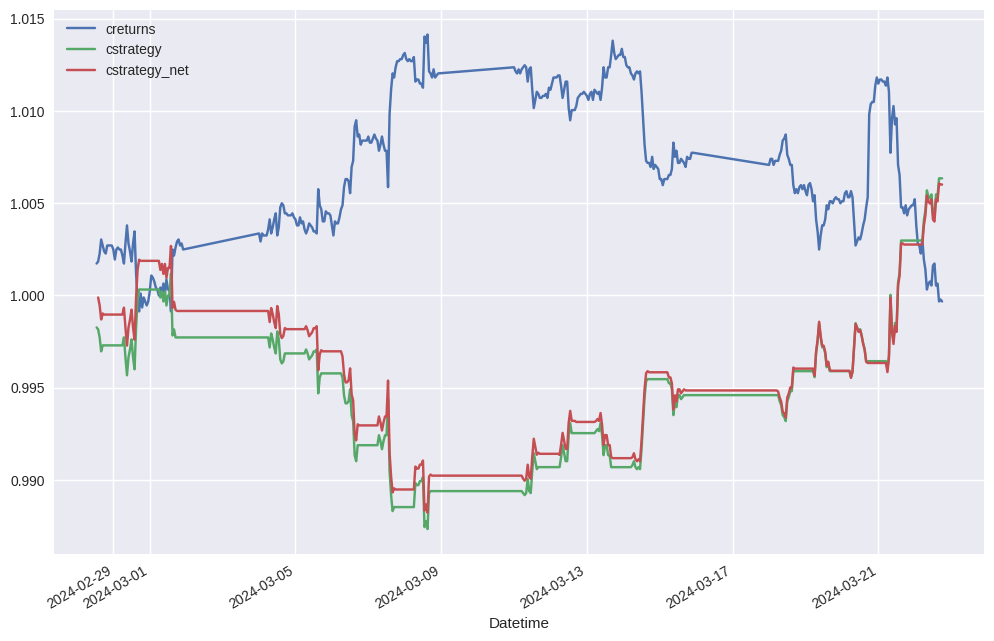

In [ ]:
test[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12, 8))
plt.show()

## Saving Model and Parameters

In [ ]:
model

In [ ]:
mu

Open                1.08290
High                1.08339
Low                 1.08242
Close               1.08290
Adj Close           1.08290
returns            -0.00002
Min/Max Points     -0.00126
dir                 0.37987
lag1               -0.00002
lag2               -0.00002
lag3               -0.00002
lag4               -0.00002
lag5               -0.00002
Ask_Dir             0.49937
SMA                -0.00002
SMA_Dir             0.50818
RSI                50.02709
RSI_Dir             0.50314
fastk              50.22876
fastd              50.21624
fastk_Dir           0.44780
fastd_Dir           0.47044
SMA_10              1.08299
SMA_30              1.08315
SMA_50              1.08330
SMA_200             1.08444
MACD               -0.00011
MACD_signal        -0.00011
MACD_hist          -0.00000
10_cross_30         0.48553
MACD_Signal_MACD    0.49560
MACD_lim            0.50314
abv_50              0.43145
abv_200             0.27799
dtype: float64

In [ ]:
std

Open                0.00605
High                0.00608
Low                 0.00600
Close               0.00603
Adj Close           0.00603
returns             0.00076
Min/Max Points      0.07935
dir                 0.48566
lag1                0.00076
lag2                0.00076
lag3                0.00075
lag4                0.00076
lag5                0.00075
Ask_Dir             0.50031
SMA                 0.00021
SMA_Dir             0.50025
RSI                 4.24292
RSI_Dir             0.50030
fastk              38.26079
fastd              22.09383
fastk_Dir           0.49758
fastd_Dir           0.49944
SMA_10              0.00605
SMA_30              0.00610
SMA_50              0.00617
SMA_200             0.00651
MACD                0.00076
MACD_signal         0.00069
MACD_hist           0.00027
10_cross_30         0.50011
MACD_Signal_MACD    0.50030
MACD_lim            0.50030
abv_50              0.49559
abv_200             0.44829
dtype: float64

In [ ]:
model.save("DNN_model")

2024-03-22 19:37:41.346917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-22 19:37:41.580037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-22 19:37:41.841144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-22 19:37:41

2024-03-22 19:37:45.537848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-22 19:37:45.854736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-22 19:37:46.281815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,50]
	 [[{{node inputs}}]]
2024-03-22 19:37:46

INFO:tensorflow:Assets written to: DNN_model/assets


In [ ]:
import pickle

In [ ]:
params = {"mu":mu, "std":std}

In [ ]:
params

{'mu': Open                1.08290
 High                1.08339
 Low                 1.08242
 Close               1.08290
 Adj Close           1.08290
 returns            -0.00002
 Min/Max Points     -0.00126
 dir                 0.37987
 lag1               -0.00002
 lag2               -0.00002
 lag3               -0.00002
 lag4               -0.00002
 lag5               -0.00002
 Ask_Dir             0.49937
 SMA                -0.00002
 SMA_Dir             0.50818
 RSI                50.02709
 RSI_Dir             0.50314
 fastk              50.22876
 fastd              50.21624
 fastk_Dir           0.44780
 fastd_Dir           0.47044
 SMA_10              1.08299
 SMA_30              1.08315
 SMA_50              1.08330
 SMA_200             1.08444
 MACD               -0.00011
 MACD_signal        -0.00011
 MACD_hist          -0.00000
 10_cross_30         0.48553
 MACD_Signal_MACD    0.49560
 MACD_lim            0.50314
 abv_50              0.43145
 abv_200             0.27799
 dtype: 

In [ ]:
pickle.dump(params, open("params.pkl", "wb"))

## Implementation

In [ ]:
import pandas as pd
import numpy as np
import tpqoa
import fxcmpy
from datetime import datetime, timedelta
import time

/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/v20-3.0.25.0-py3.8.egg/v20/request.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/mik/anaconda3/envs/tensor/lib/python3.8/site-packages/v20-3.0.25.0-py3.8.egg/v20/request.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?


__Loading Model and Parameters__

In [ ]:
# Loading the model
import keras
model = keras.models.load_model("DNN_model")

In [ ]:
model

In [ ]:
# Loading mu and std
import pickle
params = pickle.load(open("params.pkl", "rb"))
mu = params["mu"]
std = params["std"]

In [ ]:
mu

Open                1.08290
High                1.08339
Low                 1.08242
Close               1.08290
Adj Close           1.08290
returns            -0.00002
Min/Max Points     -0.00126
dir                 0.37987
lag1               -0.00002
lag2               -0.00002
lag3               -0.00002
lag4               -0.00002
lag5               -0.00002
Ask_Dir             0.49937
SMA                -0.00002
SMA_Dir             0.50818
RSI                50.02709
RSI_Dir             0.50314
fastk              50.22876
fastd              50.21624
fastk_Dir           0.44780
fastd_Dir           0.47044
SMA_10              1.08299
SMA_30              1.08315
SMA_50              1.08330
SMA_200             1.08444
MACD               -0.00011
MACD_signal        -0.00011
MACD_hist          -0.00000
10_cross_30         0.48553
MACD_Signal_MACD    0.49560
MACD_lim            0.50314
abv_50              0.43145
abv_200             0.27799
dtype: float64

In [ ]:
std

Open                0.00605
High                0.00608
Low                 0.00600
Close               0.00603
Adj Close           0.00603
returns             0.00076
Min/Max Points      0.07935
dir                 0.48566
lag1                0.00076
lag2                0.00076
lag3                0.00075
lag4                0.00076
lag5                0.00075
Ask_Dir             0.50031
SMA                 0.00021
SMA_Dir             0.50025
RSI                 4.24292
RSI_Dir             0.50030
fastk              38.26079
fastd              22.09383
fastk_Dir           0.49758
fastd_Dir           0.49944
SMA_10              0.00605
SMA_30              0.00610
SMA_50              0.00617
SMA_200             0.00651
MACD                0.00076
MACD_signal         0.00069
MACD_hist           0.00027
10_cross_30         0.50011
MACD_Signal_MACD    0.50030
MACD_lim            0.50030
abv_50              0.49559
abv_200             0.44829
dtype: float64

__[FXCM] Implementation__

In [ ]:
api = fxcmpy.fxcmpy(config_file= "FXCM.cfg")

OSError: Can not open config file: FXCM.cfg

In [ ]:
col = ["tradeId", "amountK", "currency", "grossPL", "isBuy"]

In [ ]:
class DNNTrader():
    
    def __init__(self, instrument, bar_length, window, lags, model, mu, std, units):
        self.instrument = instrument
        self.bar_length = pd.to_timedelta(bar_length) 
        self.tick_data = None
        self.raw_data = None
        self.data = None 
        self.ticks = 0
        self.last_bar = None  
        self.units = units
        self.position = 0
        
        #*****************add strategy-specific attributes here******************
        self.window = window
        self.lags = lags
        self.model = model
        self.mu = mu
        self.std = std
        #************************************************************************        
    
    def get_most_recent(self, period = "m1", number = 10000):
        while True:  
            time.sleep(5)
            df = api.get_candles(self.instrument, number = number, period = period, columns = ["bidclose", "askclose"])
            df[self.instrument] = (df.bidclose + df.askclose) / 2
            df = df[self.instrument].to_frame()
            df = df.resample(self.bar_length, label = "right").last().dropna().iloc[:-1]
            self.raw_data = df.copy()
            self.last_bar = self.raw_data.index[-1]
            if pd.to_datetime(datetime.utcnow()) - self.last_bar < self.bar_length:
                self.start_time = pd.to_datetime(datetime.utcnow()) # NEW -> Start Time of Trading Session
                break
    
    def get_tick_data(self, data, dataframe):
        
        self.ticks += 1
        print(self.ticks, end = " ", flush = True)
        
        recent_tick = pd.to_datetime(data["Updated"], unit = "ms")
        
        if recent_tick - self.last_bar > self.bar_length:
            self.tick_data = dataframe.loc[self.last_bar:, ["Bid", "Ask"]]
            self.tick_data[self.instrument] = (self.tick_data.Ask + self.tick_data.Bid)/2
            self.tick_data = self.tick_data[self.instrument].to_frame()
            self.resample_and_join()
            self.define_strategy() 
            self.execute_trades()
            
    def resample_and_join(self):
        self.raw_data = self.raw_data.append(self.tick_data.resample(self.bar_length, 
                                                             label="right").last().ffill().iloc[:-1])
        self.last_bar = self.raw_data.index[-1]  
        
    def define_strategy(self): # "strategy-specific"
        df = self.raw_data.copy()
        
        #******************** define your strategy here ************************
        df = df.append(self.tick_data.iloc[-1]) # append latest tick (== open price of current bar)
        df["returns"] = np.log(df[self.instrument] / df[self.instrument].shift())
        df["dir"] = np.where(df["returns"] > 0, 1, 0)
        df["sma"] = df[self.instrument].rolling(self.window).mean() - df[self.instrument].rolling(150).mean()
        df["boll"] = (df[self.instrument] - df[self.instrument].rolling(self.window).mean()) / df[self.instrument].rolling(self.window).std()
        df["min"] = df[self.instrument].rolling(self.window).min() / df[self.instrument] - 1
        df["max"] = df[self.instrument].rolling(self.window).max() / df[self.instrument] - 1
        df["mom"] = df["returns"].rolling(3).mean()
        df["vol"] = df["returns"].rolling(self.window).std()
        df.dropna(inplace = True)
        
        # create lags
        self.cols = []
        features = ["dir", "sma", "boll", "min", "max", "mom", "vol"]

        for lag in range(1, lags + 1):
            col = "lag{}".format(lag)
            df[col] = df["returns"].shift(lag)
            cols.append(col)
                
                
        df['Ask_Dir'] = np.where(df['returns'].shift(-1) > df.returns, 1, 0)
        cols.append('Ask_Dir')

        df['SMA'] = abstract.SMA(df['returns'], timeperiod=12)
        cols.append('SMA')
        df['SMA_Dir'] = np.where(df['SMA'].shift(-1) > df.SMA, 1, 0)
        cols.append('SMA_Dir')

        df['RSI'] = abstract.RSI(df['returns'], timeperiod=12)
        cols.append('RSI')
        df['RSI_Dir'] = np.where(df['RSI'].shift(-1) > df.RSI, 1, 0)
        cols.append('RSI_Dir')

        df['fastk'], df['fastd'] = abstract.STOCHRSI(df["returns"], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
        cols.append('fastk')
        cols.append('fastd')
        df['fastk_Dir'] = np.where(df['fastk'].shift(-1) > df.fastk, 1, 0)
        cols.append('fastk_Dir')
        df['fastd_Dir'] = np.where(df['fastd'].shift(-1) > df.fastd, 1, 0)    
        cols.append('fastd_Dir')                
                
        df.dropna(inplace = True)
        
        # standardization
        df_s = (df - self.mu) / self.std
        # predict
        df["proba"] = self.model.predict(df_s[self.cols])
        
        print(df.columns )
        
        #determine positions
        df = df.loc[self.start_time:].copy() # starting with first live_stream bar (removing historical bars)
        df["position"] = np.where(df.proba < 0.47, -1, np.nan)
        df["position"] = np.where(df.proba > 0.53, 1, df.position)
        df["position"] = df.position.ffill().fillna(0) # start with neutral position if no strong signal
        #***********************************************************************
        
        self.data = df.copy()
    
    def execute_trades(self):
        if self.data["position"].iloc[-1] == 1:
            if self.position == 0:
                order = api.create_market_buy_order(self.instrument, self.units)
                self.report_trade(order, "GOING LONG")  
            elif self.position == -1:
                order = api.create_market_buy_order(self.instrument, self.units * 2)
                self.report_trade(order, "GOING LONG")  
            self.position = 1
        elif self.data["position"].iloc[-1] == -1: 
            if self.position == 0:
                order = api.create_market_sell_order(self.instrument, self.units)
                self.report_trade(order, "GOING SHORT")  
            elif self.position == 1:
                order = api.create_market_sell_order(self.instrument, self.units * 2)
                self.report_trade(order, "GOING SHORT")  
            self.position = -1
        elif self.data["position"].iloc[-1] == 0: 
            if self.position == -1:
                order = api.create_market_buy_order(self.instrument, self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            elif self.position == 1:
                order = api.create_market_sell_order(self.instrument, self.units)
                self.report_trade(order, "GOING NEUTRAL")  
            self.position = 0

    def report_trade(self, order, going):
        time = order.get_time()
        units = api.get_open_positions().amountK.iloc[-1]
        price = api.get_open_positions().open.iloc[-1]
        unreal_pl = api.get_open_positions().grossPL.sum()
        print("\n" + 100* "-")
        print("{} | {}".format(time, going))
        print("{} | units = {} | price = {} | Unreal. P&L = {}".format(time, units, price, unreal_pl))
        print(100 * "-" + "\n")

In [ ]:
trader = DNNTrader("EUR/USD", bar_length = "20min", 
                   window = 50, lags = 5, model = model, mu = mu, std = std, units = 100)

In [ ]:

trader.get_most_recent()
api.subscribe_market_data(trader.instrument, (trader.get_tick_data, ))

In [ ]:
'''
api.unsubscribe_market_data(trader.instrument)
if len(api.get_open_positions()) != 0: # if we have final open position(s) (netting and hedging)
    api.close_all_for_symbol(trader.instrument)
    print(2*"\n" + "{} | GOING NEUTRAL".format(str(datetime.utcnow())) + "\n")
    time.sleep(20)
    print(api.get_closed_positions_summary()[col])
    trader.position = 0
'''

'\napi.unsubscribe_market_data(trader.instrument)\nif len(api.get_open_positions()) != 0: # if we have final open position(s) (netting and hedging)\n    api.close_all_for_symbol(trader.instrument)\n    print(2*"\n" + "{} | GOING NEUTRAL".format(str(datetime.utcnow())) + "\n")\n    time.sleep(20)\n    print(api.get_closed_positions_summary()[col])\n    trader.position = 0\n'

In [ ]:
#trader.data

In [ ]:
#api.close()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 